## REPORT: Pytorch DDQN
#### Wendell Luckow - 8/15/18

Note: Code here is almost identical to the ipython notebook

In [1]:
#Import Dependencies
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import random
import sys
from unityagents import UnityEnvironment
import numpy as np

In [2]:
#Initialize Unity Environment executable
env = UnityEnvironment(file_name="./Banana_Windows_x86_64\Banana_Windows_x86_64/Banana.exe")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


# Network Architecture
### Network Architecture

1. Input of size 37

2. Linear hidden layer with 512 neurons

3. Rectified linear activation

4. Linear hidden layer with 256 neurons

5. Rectified linear activation

6. Output of size 4

Uses uniform xavier weight initialization: http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

In [3]:
#Create the neural network
class DDQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DDQN, self).__init__()
        
        hidden_size_0 = 512
        self.layer_0 = nn.Linear(input_size, hidden_size_0)
        torch.nn.init.xavier_uniform_(self.layer_0.weight)
        
        hidden_size_1 = 256
        self.layer_1 = nn.Linear(hidden_size_0, hidden_size_1)
        torch.nn.init.xavier_uniform_(self.layer_1.weight)
        
        self.layer_2 = nn.Linear(hidden_size_1, output_size)
        torch.nn.init.xavier_uniform_(self.layer_2.weight)
    def forward(self, state, is_training = True):
        f0 = F.relu(self.layer_0(state))
        f1 = F.relu(self.layer_1(f0))
        f2 = self.layer_2(f1)
        return f2

Training done on a single NVIDIA GTX 980

In [4]:
#Use a gpu to train and run
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Learning Algorithm

### DDQN

https://arxiv.org/abs/1509.06461

The agent uses a Double Deep Q-Network (DDQN). There are two identical neural nets, "Q_online" and "Q_target". 
At every step, the agent recieves a state from the environment and executes an action according to the policy. To determine which greedy action to take, the "Q_online" network is used.

The agent then observes the following state (resulting from the action) as well as a reward. All of this information is collected and saved into the experience replay memory. 

The goal of the network is to estimate the sum of rewards when following the policy from some given state. To do this, it sums together the current reward along with the Q-value of the next state. Because the policy is designed to pick the best estimated action, the "Q_online" network is used to determine what action is predicted to be the best when starting in the next state. Then the "Q_target" network uses that action to estimate the Q-value of the next state, which is then added with the reward to update the Q-value for the current state.

At every time step, a minibatch is randomly drawn (uniformly) from the experience replay memory to update network weights. A single update step is performed on the "Q_online" network using an ADAM Optimizer (https://arxiv.org/abs/1412.6980).

The code for the training step can be found in the class method, "train_batch", below.

### Parameters:

1. Batch size: 1

2. Learning rate: 0.0001

3. Initial Epsilon: 1.0

4. Gamma: 0.9

5. Weight copy frequency: Every 2000

6. Epsilon linear decay rate: -1/100000 every action

7. Minimum Epsilon: 0.1

8. Replay size: 150000

9. Training starts and epsilon begins decaying after 10000 steps have occured

### Loss Function:
Mean Squared Error

### Scoring:

+1 for collecting a yellow banana

-1 for collecting a blue banana

-0.03 elsewhere

In [5]:
class DDQN_run(object):
    def __init__(self):
        env_info = env.reset(train_mode=True)[brain_name]
        self.state_size = env_info.vector_observations[0].shape[0]
        action_size = brain.vector_action_space_size
        self.action_size = action_size
        
        self.Q_online = DDQN(self.state_size, action_size)
        self.Q_target = DDQN(self.state_size, action_size)
        self.Q_online = self.Q_online.cuda()
        self.Q_target = self.Q_target.cuda()
        self.optimizer = torch.optim.Adam(self.Q_online.parameters(), lr = .0001)
        
        self.update_every = 2000 #number of steps before copying weights
        self.D = [] #initialize experience replay
        self.batch_size = 1
        self.epsilon = 1.0 #initial random action probability
        self.gamma = 0.9
        self.step = 0
        
    def decay_epsilon(self, step):
        """
        Decay epsilon probability (linear)
        Input: step number to calculate epsilon decay (int)
        """
        slope = (-1.0)/(100000)
        self.epsilon = max(0.1, slope * step + 1.0)
        
    def update_replay_memory(self, state, action, reward, next_state, done):
        """
        input is the <state, action, reward, state+1, done> values
        Adds as a tuple (list) to the experience replay memory
        Limit the size of the experience replay
        """
        #negative reward when no bananas are picked up to create urgency
        if reward == 0:
            reward = -0.03
            
        #add to experience replay
        self.D.append([state, action, reward, next_state, done])
        
        #limit the size of the experience replay
        max_replay_size = 150000
        len_replay = len(self.D)
        if len_replay > max_replay_size:
            self.D = self.D[1:]
        
    def sample_replay_memory(self):
        """
        returns a batch for training of size self.batch_size
        """
        return random.sample(self.D, k = self.batch_size)
        
    def copy_weights(self):
        """
        copy weight parameters from Q_online to Q_target
        """
        for target_param, online_param in zip(self.Q_target.parameters(), self.Q_online.parameters()):
            target_param.data.copy_(online_param)
            
    def pick_action(self, state):
        """
        Input: State feature array
        Output: Action
        
        Picked randomly with an epsilon probability
        """
        if random.random() < self.epsilon:
            return int(random.choice(np.arange(self.action_size)))
        else:
            state = torch.from_numpy(state).float().to(device)
            return int(torch.argmax(self.Q_online(state).detach()))
        
    def train_batch(self):
        """
        update online weights using a batch sampled from experience replay
        """
        #collect a minibatch
        batch = self.sample_replay_memory()
        
        #split the batch up
        x, y, r, x_next, d = [], [], [], [], []
        for i in range(len(batch)):
            x.append(batch[i][0])
            y.append(batch[i][1])
            r.append(batch[i][2])
            x_next.append(batch[i][3])
            d.append(batch[i][4])
        x = torch.from_numpy(np.array(x)).float().to(device)
        y = torch.from_numpy(np.array(y)).float().to(device)
        r = torch.from_numpy(np.array(r)).float().to(device)
        x_next = torch.from_numpy(np.array(x_next)).float().to(device)
        d = torch.from_numpy(np.array(d).astype(int)).float().to(device)
        
        #train
        Q_max_index = torch.argmax(self.Q_online(x_next).detach(), dim = 1)
        Q_targets_next = self.Q_target(x_next).gather(1, Q_max_index.type(torch.cuda.LongTensor).unsqueeze(1))
        Q_expected = self.Q_online(x).gather(1, y.type(torch.cuda.LongTensor).unsqueeze(1))
        
        Q_targets = r + (self.gamma * Q_targets_next * (1 - d))
        
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def load_weights(self):
        """
        load the saved weights and copy them to both Q nets
        """
        self.Q_online.load_state_dict(torch.load('checkpoint.pth'))
        self.copy_weights()
        
    def run_saved_model(self):
        """
        Watch a game played by a trained agent
        """
        self.load_weights()
        self.epsilon = 0.1
        env_info = env.reset(train_mode=False)[brain_name]
        state = env_info.vector_observations[0]
        done = False
        while not done:
            action = self.pick_action(state)
            env_info = env.step(action)[brain_name]
            state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
                        
    def train(self):
        """
        train the agent according to DDQN
        """
        best_score = float('-inf') #initialize best score
        num_eps = 0 #initialize counter
        total_eps = 1800 #the number of games to simulate
        one_hundred_episode_average = []
        rolling_episode_averages = []
        
        #for plotting
        plotting_x = []
        plotting_epsilon = []
        plotting_best_score = []
        plotting_raw_score = []
        plotting_avg_score = []
        
        for i in range(total_eps):
            num_eps += 1
            score = 0 #initialize score
            env_info = env.reset(train_mode=True)[brain_name] #set to False to watch slower
            state = env_info.vector_observations[0]
            done = False
            
            while not done:
                self.step += 1 #keep track of total steps executed by the agent
                action = self.pick_action(state)
                env_info = env.step(action)[brain_name]
                next_state = env_info.vector_observations[0]
                reward = env_info.rewards[0]
                done = env_info.local_done[0]
                score += reward

                #update replay memory
                self.update_replay_memory(state, action, reward, next_state, done)

                #sample batch from replay memory and train network
                start_train_step = 10000
                if len(self.D) > self.batch_size * 10 and len(self.D) > start_train_step:
                    self.decay_epsilon(step = self.step - start_train_step)
                    self.train_batch()

                #copy weights from online network to target network
                if self.step % self.update_every == 0:
                    self.copy_weights()

                #transition to the next state
                state = next_state

                #print out current stats
                if len(rolling_episode_averages) > 0:
                    printout_avg = rolling_episode_averages[-1]
                else:
                    printout_avg = 0
                printout = ('{}/{} | {:.2f}% | Step {} | Score: {} | '
                            'Best score: {} | Epsilon: {:.3f} | Rolling 100 avg: {:.3f}'.format(num_eps, 
                                                                                                total_eps,
                                                                                                100 * num_eps / total_eps,
                                                                                                self.step, 
                                                                                                score, 
                                                                                                best_score,
                                                                                                self.epsilon,
                                                                                                printout_avg))
                sys.stdout.write('\r{}          '.format(printout))
                sys.stdout.flush()
                
            #keep track of ongoing best score
            if score > best_score:
                best_score = score                    
                
            #keep track of ongoing 100-game average score
            one_hundred_episode_average.append(score)
            one_hundred_episode_average = one_hundred_episode_average[-100:]
            if len(one_hundred_episode_average) >= 100:
                rolling_episode_averages.append(np.mean(one_hundred_episode_average))
                if np.mean(one_hundred_episode_average) > 13:
                    #if the 100-game average is greater than 13, print stats and terminate program
                    printout = ('{}/{} | {:.2f}% | Step {} | Score: {} | '
                                'Best score: {} | Epsilon: {:.3f} | Rolling 100 avg: {:.3f}'.format(num_eps, 
                                                                                                    total_eps,
                                                                                                    100 * num_eps / total_eps,
                                                                                                    self.step, 
                                                                                                    score, 
                                                                                                    best_score,
                                                                                                    self.epsilon,
                                                                                                    rolling_episode_averages[-1]))
                    sys.stdout.write('\r{}          '.format(printout))
                    sys.stdout.flush()
                    torch.save(self.Q_online.state_dict(), 'checkpoint.pth')
                    print("")
                    print("Weights saved as 'checkpoint.pth'")
                    print("Solved in {} episodes!".format(num_eps))
                    plotting_x.append(num_eps)
                    plotting_epsilon.append(self.epsilon)
                    plotting_best_score.append(best_score)
                    plotting_raw_score.append(score)
                    plotting_avg_score.append(np.mean(one_hundred_episode_average))
                    break
            
            #update plotting lists
            plotting_x.append(num_eps)
            plotting_epsilon.append(self.epsilon)
            if best_score != float('-inf'):
                plotting_best_score.append(best_score)
            plotting_raw_score.append(score)
            plotting_avg_score.append(np.mean(one_hundred_episode_average))

        print("")
        print("__________________")
        print("Done.")
        return plotting_x, plotting_epsilon, plotting_best_score, plotting_raw_score, plotting_avg_score
        

In [6]:
plotting_x, plotting_epsilon, plotting_best_score, plotting_raw_score, plotting_avg_score = DDQN_run().train()

1401/1800 | 77.83% | Step 420300 | Score: 16.0 | Best score: 22.0 | Epsilon: 0.100 | Rolling 100 avg: 13.060          
Weights saved as 'checkpoint.pth'
Solved in 1401 episodes!

__________________
Done.


In [7]:
#Close the environment
env.close()

# Results

In this section, the results are plotted and discussed. There are four graphs, each corresponding to different metrics. In the top left, the raw score at the end of each episode is plotted. In the top right, the epsilon parameter is plotted to visualize the decay. In the bottom left, the overall ongoing top score is plotted, and in the bottom right, the rolling 100-game average score is plotted.

Growth is fairly consistent throughout the training, but the 100-game average score does slow down in growth pretty early, at around game 500. In this particular training run, plotted below, the top score reached is 22 which is likely due to the randomness of the environment (access to large groups of yellow bananas). However it is worth mentioning that all score-related plots below show growth even towards the very end which hints that there is still room for improvement beyond an average rolling score of 13.

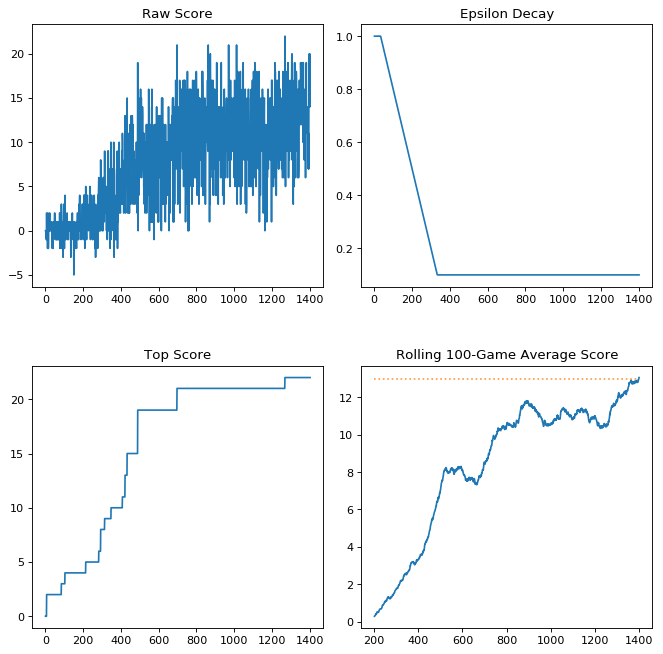

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 10), dpi = 80)
ax1 = plt.subplot2grid((2, 4), (0, 0), rowspan = 1, colspan = 2)
ax2 = plt.subplot2grid((2, 4), (0, 2), rowspan = 1, colspan = 2)
ax3 = plt.subplot2grid((2, 4), (1, 0), rowspan = 1, colspan = 2)
ax4 = plt.subplot2grid((2, 4), (1, 2), rowspan = 1, colspan = 2)
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

ax1.plot(plotting_x, plotting_raw_score)
ax1.set_title("Raw Score", fontsize = 12)

ax2.plot(plotting_x, plotting_epsilon)
ax2.set_title("Epsilon Decay", fontsize = 12)

temp_best_x = plotting_x[-len(plotting_best_score):]
ax3.plot(temp_best_x, plotting_best_score)
ax3.set_title("Top Score", fontsize = 12)

plotting_avg_score_copy = plotting_avg_score[100:]
temp_avg_x = plotting_x[-len(plotting_avg_score_copy):]
ax4.plot(temp_avg_x, plotting_avg_score_copy)
min_x, max_x = temp_avg_x[0], temp_avg_x[-1]
min_y, max_y = 13, 13
ax4.plot([min_x, max_x], [min_y, max_y], ls = ':', alpha = 0.8)
ax4.set_title("Rolling 100-Game Average Score", fontsize = 12)

# Other ideas for future work

The above implementation uses a Double Q-Network. However, a standard Deep Q-Network was tested but had worse results and never solved the environment using the selected hyperparameters. 

One of the major downsides to reinforcement learning is the training time required to train an agent to do something even as simple as this. One way to increase learning efficacy would be to improve the exploration strategy. Currently, an epsilon-greedy policy is used, however there is research done on more efficient methods. For instance, a noisy network (https://arxiv.org/abs/1706.10295 and https://arxiv.org/abs/1706.01905) would work, as well as potentially adding in a curiosity metric (https://arxiv.org/pdf/1705.05363.pdf). Curiosity is particularly interesting because it works to better understand how the environment works by mapping two consecutive states to an action that would lead the agent from one state to the other. It also achieves an understanding by mapping a state and an action to a predicted following state which implies a deep understanding of how the environment works.

Another potential downside to the current implementation is the size of the network architecture. There are many parameters to learn given a simple environment which lends itself nicely to something like the Lottery Ticket Hypothesis (https://arxiv.org/pdf/1803.03635.pdf). A method such as the one described in that paper could be used to create a much smaller neural net which would result in an agent that learns faster and can learn quickly on weaker computer hardware. The paper also explains that smaller neural networks can sometimes achieve better results which would mean a smarter, more adaptable agent as well.